In [1]:
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import json

In [2]:
with open('test_result.json') as json_file:
    test_result = json.load(json_file)

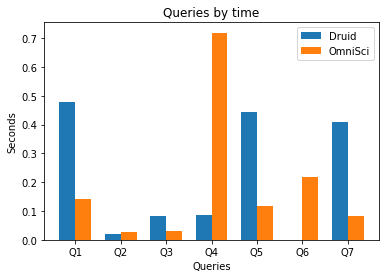

In [8]:
labels = test_result["queries"].keys()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

druid_means = [mean(test_result["timings"]["druid"][label]) for label in labels]
omnisci_means = [mean(test_result["timings"]["omnisci"][label]) for label in labels]


fig, ax = plt.subplots()
ax.bar(x - width/2, druid_means, width, label='Druid')
ax.bar(x + width/2, omnisci_means, width, label='OmniSci')

ax.set_title('Queries by time')
ax.set_xlabel('Queries')
ax.set_ylabel('Seconds')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()